---
# Loan Payment Status Prediction
---

## Table of Contents
---
1. [Loading and Setup](#loadingandsetup)
2. [Assessment](#assessment)
3. [Split into Training and Validation Datasets](#split)
4. [Baseline Modeling](#baseline)
    - [Logistic Regression](#1)
    - [Support Vector Machine](#2)
    - [Decision Tree](#3)
    - [Random Forest](#4)
    - [XGBoost](#5)
5. [Hyperparameter Tuning](#hyperparameter)
    - [Logistic Regression](#a)
    - [Support Vector Machine](#b)
    - [Decision Tree](#c)
    - [Random Forest](#d)
    - [XGBoost](#e)
6. [Tune the models](#tune)
7. [Model Selection](#select)
8. [Model Evaluation](#evaluate)

## Loading and Setup <a class="anchor" id="loadingandsetup"></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import time
import pickle
import os
# Filter warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# Load the datasets
train_df = pd.read_parquet('dataset/train_dataset.parquet')
test_df = pd.read_parquet('dataset/test_dataset.parquet')

In [3]:
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Assessment <a class="anchor" id="assessment"></a>

### Train Data

In [4]:
# Display the first 5 rows of train data to get an overview of the data
train_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,earliest_cr_year,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,initial_list_status_w,application_type_Joint App,loan_status
0,0.411765,0.411765,0.411765,0.0,0.162653,0.338074,0.015893,0.089071,0.000000,0.108108,0.107527,0.0,0.140625,0.043478,0.013267,0.447506,0.065421,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.600000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.676471,0.676471,0.676471,1.0,0.577524,0.447021,0.026730,0.253851,0.066667,0.027027,0.026882,0.0,0.140625,0.000000,0.031700,0.483246,0.168224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.872727,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.411765,0.411765,0.411765,0.0,0.189269,0.341412,0.046797,0.128641,0.000000,0.270270,0.268817,0.6,0.281250,0.000000,0.040715,0.294862,0.261682,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.600000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.316176,0.316176,0.316176,0.0,0.281791,0.271637,0.007866,0.218004,0.000000,0.054054,0.053763,0.0,0.062500,0.000000,0.020613,0.588235,0.196262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.690909,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.264706,0.264706,0.264706,0.0,0.224757,0.222903,0.011880,0.087391,0.000000,0.108108,0.107527,0.2,0.046875,0.000000,0.008994,0.446761,0.056075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.800000,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [5]:
# Display the last 5 rows of the train data to get an overview of the data  
train_df.tail()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,earliest_cr_year,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,initial_list_status_w,application_type_Joint App,loan_status
27391,0.284751,0.284751,0.284751,0.0,0.249261,0.241881,0.018642,0.168478,0.056254,0.061236,0.060906,0.084381,0.176027,0.025135,0.015186,0.465594,0.205759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.596017,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0
27392,0.249576,0.249576,0.249576,0.0,0.081960,0.198987,0.029849,0.157311,0.000000,0.282614,0.281095,0.000000,0.187049,0.000000,0.063611,0.361683,0.312410,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.890909,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.257214,0.0,0.0
27393,0.289427,0.289427,0.289427,0.0,0.332066,0.253502,0.014361,0.219024,0.047125,0.079451,0.079024,0.470687,0.114897,0.015367,0.016247,0.534641,0.116580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.864108,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0
27394,0.712357,0.712357,0.712357,1.0,0.544149,0.462675,0.025819,0.193246,0.000000,0.011559,0.011497,0.157233,0.156250,0.000000,0.010436,0.574177,0.154235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.779188,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0
27395,0.303379,0.303379,0.302538,0.0,0.133925,0.246652,0.022270,0.212239,0.000000,0.158281,0.157430,0.200000,0.305851,0.000000,0.051815,0.439693,0.284475,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.836412,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0


In [6]:
# Randomly sample 15 rows from the train data
train_df.sample(15)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,earliest_cr_year,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,initial_list_status_w,application_type_Joint App,loan_status
17604,0.278393,0.278393,0.278393,0.000000,0.281791,0.239417,0.012065,0.071304,0.000000,0.287580,0.286034,0.200000,0.111248,0.043478,0.006242,0.111975,0.163184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.747634,0.0,1.0,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15609,0.205882,0.205882,0.205882,0.000000,0.307140,0.179319,0.019907,0.127619,0.000000,0.027027,0.026882,0.000000,0.156250,0.086957,0.014418,0.364855,0.224299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.781818,0.0,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
20759,0.215235,0.215235,0.215235,0.000000,0.255626,0.183795,0.042146,0.232027,0.298464,0.056825,0.056520,0.231798,0.136539,0.050391,0.030001,0.379035,0.276972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.586573,0.0,0.0,0.0,0.579494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
25649,0.434278,0.434278,0.434278,1.000000,0.619772,0.292321,0.026198,0.168305,0.000000,0.014230,0.014154,0.389390,0.198214,0.000000,0.040752,0.454843,0.203661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.747384,0.0,0.0,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5970,0.229412,0.229412,0.229412,0.000000,0.230672,0.193827,0.018703,0.186683,0.000000,0.027027,0.026882,0.200000,0.296875,0.000000,0.023910,0.386448,0.495327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.836364,0.0,1.0,0.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2165,0.705882,0.705882,0.705882,1.000000,0.577524,0.466604,0.030743,0.117982,0.000000,0.216216,0.215054,0.200000,0.328125,0.000000,0.021597,0.243485,0.280374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.927273,0.0,1.0,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8990,0.558824,0.558824,0.558824,1.000000,0.307140,0.317449,0.020710,0.113894,0.000000,0.054054,0.053763,0.200000,0.109375,0.000000,0.021279,0.563663,0.084112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.818182,0.0,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
11056,0.323529,0.323529,0.323529,0.000000,0.332066,0.283079,0.036764,0.080383,0.000000,0.270270,0.268817,0.200000,0.125000,0.000000,0.008276,0.458675,0.186916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.654545,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
6036,0.323529,0.323529,0.323529,0.000000,0.187579,0.268344,0.019104,0.077900,0.000000,0.027027,0.026882,0.400000,0.218750,0.043478,0.020763,0.344006,0.140187,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

This quick check seems to show that the data is loaded correctly now.

In [7]:
# Get information about the train data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27396 entries, 0 to 27395
Data columns (total 70 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            27396 non-null  float64
 1   funded_amnt                          27396 non-null  float64
 2   funded_amnt_inv                      27396 non-null  float64
 3   term                                 27396 non-null  float64
 4   int_rate                             27396 non-null  float64
 5   installment                          27396 non-null  float64
 6   annual_inc                           27396 non-null  float64
 7   dti                                  27396 non-null  float64
 8   delinq_2yrs                          27396 non-null  float64
 9   fico_range_low                       27396 non-null  float64
 10  fico_range_high                      27396 non-null  float64
 11  inq_last_6mths              

In [8]:
# Get a statistical summary of the train data
train_df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,earliest_cr_year,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,initial_list_status_w,application_type_Joint App,loan_status
count,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000,27396.000000
mean,0.424273,0.424273,0.424073,0.352774,0.330396,0.314067,0.027485,0.146731,0.021904,0.167929,0.167027,0.133697,0.177501,0.010817,0.026224,0.393520,0.201764,0.018284,0.018475,0.023890,0.035890,0.042898,0.050308,0.054943,0.060753,0.057161,0.067602,0.059236,0.062568,0.070559,0.052999,0.041858,0.036884,0.032376,0.033136,0.023331,0.024551,0.019607,0.019980,0.017981,0.012334,0.007828,0.007836,0.006933,0.002896,0.003695,0.001488,0.002926,0.000717,0.000616,0.000308,0.773537,0.106557,0.422449,0.416241,0.318917,0.230676,0.598559,0.049941,0.003417,0.019556,0.009275,0.006070,0.055252,0.000519,0.012502,0.005616,0.876642,0.006244,0.500000
std,0.248122,0.248122,0.247986,0.473644,0.182873,0.180160,0.020162,0.060421,0.053685,0.150542,0.149735,0.173767,0.085944,0.026039,0.031657,0.168806,0.107976,0.133229,0.134243,0.151951,0.185237,0.202224,0.217915,0.227365,0.238299,0.231318,0.250408,0.235173,0.241693,0.255254,0.222993,0.199274,0.187081,0.175823,0.177478,0.149504,0.153835,0.137496,0.138837,0.131720,0.109136,0.085850,0.087245,0.081333,0.052201,0.058780,0.035920,0.050973,0.024969,0.022402,0.016111,0.121925,0.301880,0.488733,0.489811,0.462742,0.419931,0.486635,0.215498,0.055917,0.134792,0.093885,0.075333,0.225907,0.021822,0.106618,0.072358,0.319369,0.074615,0.500009
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.235294,0.235294,0.235294,0.000000,0.187579,0.183456,0.016696,0.101850,0.000000,0.054054,0.053763,0.000000,0.119353,0.000000,0.010289,0.270505,0.123071,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.709091,0.000000,0.000000,0.

### Test Data

In [9]:
# Display the first 5 rows of the test data to get an overview of the data
test_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,earliest_cr_year,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,initial_list_status_w,application_type_Joint App,loan_status
0,0.794118,0.794118,0.794118,0.0,0.108576,0.638507,0.277573,0.023582,0.000000,0.243243,0.241935,0.0,0.125000,0.0,0.098225,0.588235,0.149533,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.745455,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.464706,0.464706,0.464706,0.0,0.281791,0.398295,0.013887,0.167044,0.000000,0.162162,0.161290,0.0,0.156250,0.0,0.009498,0.423678,0.196262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.818182,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.676471,0.676471,0.676471,1.0,0.133925,0.348722,0.056831,0.173031,0.066667,0.135135,0.134409,0.0,0.171875,0.0,0.340650,0.681310,0.261682,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.618182,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.676471,0.676471,0.676471,0.0,0.000000,0.522777,0.046797,0.179163,0.000000,0.459459,0.456989,0.0,0.187500,0.0,0.111296,0.453462,0.214953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.581818,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.676471,0.676471,0.675000,1.0,0.249261,0.373018,0.022716,0.138424,0.000000,0.297297,0.295699,0.0,0.125000,0.0,0.009972,0.331348,0.084112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.909091,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:
# Display the last 5 rows of the test data to get an overview of the data
test_df.tail()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,earliest_cr_year,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,initial_list_status_w,application_type_Joint App,loan_status
4162,0.308824,0.308824,0.308824,0.0,0.260245,0.263254,0.006662,0.148938,0.000000,0.378378,0.376344,0.0,0.078125,0.043478,0.000811,0.037975,0.056075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.909091,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4163,0.157353,0.157353,0.157353,0.0,0.386988,0.141966,0.006020,0.077097,0.000000,0.270270,0.268817,0.0,0.093750,0.000000,0.011396,0.270290,0.056075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.909091,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4164,0.558824,0.558824,0.557353,0.0,0.281791,0.478552,0.044790,0.198365,0.000000,0.162162,0.161290,0.0,0.109375,0.000000,0.281839,0.662695,0.074766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.836364,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4165,0.308824,0.308824,0.308824,0.0,0.162653,0.253806,0.015893,0.125210,0.066667,0.027027,0.026882,0.0,0.046875,0.000000,0.012660,0.426657,0.074766,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.800000,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4166,0.535294,0.535294,0.535294,0.0,0.000000,0.413611,0.026730,0.022268,0.000000,0.243243,0.241935,0.0,0.156250,0.000000,0.004625,0.082651,0.168224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.781818,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [11]:
# Randomly sample 15 rows from the test data
test_df.sample(15)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,earliest_cr_year,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,initial_list_status_w,application_type_Joint App,loan_status
2835,0.441176,0.441176,0.439706,1.0,0.332066,0.252991,0.030021,0.173469,0.0,0.162162,0.161290,0.0,0.109375,0.000000,0.015322,0.419955,0.261682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.890909,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3153,0.186029,0.186029,0.186029,0.0,0.544149,0.177491,0.078905,0.013361,0.0,0.108108,0.107527,0.4,0.125000,0.304348,0.008966,0.234550,0.121495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.618182,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
595,0.218382,0.218382,0.218382,0.0,0.517533,0.205593,0.009070,0.200336,0.0,0.027027,0.026882,0.0,0.156250,0.000000,0.025586,0.372301,0.149533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.909091,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2407,0.445588,0.445588,0.445588,1.0,0.662019,0.306838,0.014689,0.101993,0.0,0.324324,0.322581,0.0,0.125000,0.000000,0.008764,0.650037,0.056075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.800000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2709,0.264706,0.264706,0.264706,0.0,0.230672,0.223401,0.028737,0.099803,0.0,0.189189,0.188172,0.0,0.125000,0.000000,0.033046,0.619509,0.074766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.818182,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2430,0.136765,0.136765,0.136765,0.0,0.386988,0.123773,0.017499,0.066073,0.0,0.027027,0.026882,0.8,0.156250,0.043478,0.005430,0.173492,0.252336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.781818,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3914,0.676471,0.676471,0.676471,1.0,0.352767,0.395591,0.027533,0.142805,0.0,0.135135,0.134409,0.0,0.171875,0.000000,0.055405,0.593448,0.140187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.618182,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3086,0.535294,0.535294,0.535294,1.0,0.129278,0.273593,0.052817,0.070453,0.0,0.243243,0.241935,0.0,0.156250,0.000000,0.023147,0.291139,0.233645,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.672727,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2026,0.000000,0.000000,0.000000,0.0,0.224757,0.001533,0.015893,0.041834,0.0,0.351351,0.349462,0.0,0.046875,0.000000,0.021745,0.324646,0.009346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.763636,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2222,0.111765,0.111765,0.111765,0.0,0.307140,0.098367,0.040777,0.136672,

This quick check seems to show that the data is loaded correctly now.

In [12]:
# Get information about the test data
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4167 entries, 0 to 4166
Data columns (total 70 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            4167 non-null   float64
 1   funded_amnt                          4167 non-null   float64
 2   funded_amnt_inv                      4167 non-null   float64
 3   term                                 4167 non-null   float64
 4   int_rate                             4167 non-null   float64
 5   installment                          4167 non-null   float64
 6   annual_inc                           4167 non-null   float64
 7   dti                                  4167 non-null   float64
 8   delinq_2yrs                          4167 non-null   float64
 9   fico_range_low                       4167 non-null   float64
 10  fico_range_high                      4167 non-null   float64
 11  inq_last_6mths                

In [13]:
# Get a statistical summary of the test data
test_df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D1,D2,D3,D4,D5,E1,E2,E3,E4,E5,F1,F2,F3,F4,F5,G1,G2,G3,G4,G5,earliest_cr_year,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,initial_list_status_w,application_type_Joint App,loan_status
count,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.00000,4167.00000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000,4167.000000
mean,0.414134,0.414134,0.413938,0.309575,0.293546,0.307405,0.028483,0.140749,0.023390,0.188975,0.187959,0.122150,0.174196,0.010110,0.026815,0.385174,0.200099,0.023998,0.025198,0.034317,0.052316,0.049916,0.057835,0.066715,0.066955,0.057115,0.069834,0.059755,0.056635,0.057355,0.046076,0.036957,0.029758,0.025198,0.027118,0.022318,0.017519,0.017519,0.015119,0.007919,0.010079,0.006479,0.00504,0.00408,0.001920,0.001920,0.001680,0.001680,0.000720,0.000480,0.000480,0.762345,0.108711,0.403408,0.401488,0.284617,0.249100,0.575714,0.053756,0.005280,0.024238,0.010319,0.006479,0.050396,0.000480,0.008399,0.005760,0.868731,0.005280,0.821934
std,0.256075,0.256075,0.255897,0.462374,0.179165,0.187904,0.032038,0.064629,0.060958,0.167534,0.166633,0.178988,0.089411,0.026739,0.032626,0.178535,0.111500,0.153061,0.156745,0.182065,0.222690,0.217798,0.233460,0.249557,0.249973,0.232091,0.254898,0.237061,0.231172,0.232548,0.209676,0.188679,0.169938,0.156745,0.162446,0.147734,0.131209,0.131209,0.122040,0.088648,0.099900,0.080244,0.07082,0.06375,0.043779,0.043779,0.040957,0.040957,0.026825,0.021905,0.021905,0.134950,0.311314,0.490640,0.490258,0.451286,0.432544,0.494293,0.225562,0.072477,0.153806,0.101070,0.080244,0.218787,0.021905,0.091273,0.075682,0.337735,0.072477,0.382614
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.054545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.205882,0.205882,0.205882,0.000000,0.162653,0.170132,0.015963,0.092648,0.000000,0.054054,0.053763,0.000000,0.109375,0.000000,0.009791,0.253909,0.121495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.690909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

## Split into Training and Validation Datasets <a class="anchor" id="split"></a>

In [14]:
# Separate features and target variable from the training dataset
X_train_full = train_df.drop(columns=['loan_status'])
y_train_full = train_df['loan_status']

# Split the training dataset into training and validation subsets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Separate features and target variable from the test dataset
X_test = test_df.drop(columns=['loan_status'])
y_test = test_df['loan_status']

# Check the shapes of the datasets
X_train.shape, X_val.shape, X_test.shape

((21916, 69), (5480, 69), (4167, 69))

## Baseline Modeling

#### Logistic Regression


In [15]:
# Initialize the model
log_reg = LogisticRegression(random_state=42)

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions
preds = log_reg.predict(X_val)

# Compute metrics
accuracy_lg = accuracy_score(y_val, preds)
precision_lg = precision_score(y_val, preds)
recall_lg = recall_score(y_val, preds)
f1_lg = f1_score(y_val, preds)
conf_mat_lg = confusion_matrix(y_val, preds)
clf_report_lg = classification_report(y_val, preds)

# Print metrics
print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_lg}")
print(f"Precision: {precision_lg}")
print(f"Recall: {recall_lg}")
print(f"F1 Score: {f1_lg}")
print("Confusion Matrix:")
print(conf_mat_lg)
print("Classification Report:")
print(clf_report_lg)

Logistic Regression Metrics:
Accuracy: 0.6618613138686131
Precision: 0.6829846032372681
Recall: 0.6223021582733813
F1 Score: 0.6512328251458686
Confusion Matrix:
[[1897  803]
 [1050 1730]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.70      0.67      2700
         1.0       0.68      0.62      0.65      2780

    accuracy                           0.66      5480
   macro avg       0.66      0.66      0.66      5480
weighted avg       0.66      0.66      0.66      5480



### Support Vector Machine


This model will be tuned in the future, below is the code.

In [16]:
# Initialize the model
svm = SVC(random_state=42)

#Train the model
svm.fit(X_train, y_train)

#Make predictions
preds = svm.predict(X_val)

#Compute metrics
accuracy_svm = accuracy_score(y_val, preds)
precision_svm = precision_score(y_val, preds)
recall_svm = recall_score(y_val, preds)
f1_svm = f1_score(y_val, preds)
conf_mat_svm = confusion_matrix(y_val, preds)
clf_report_svm = classification_report(y_val, preds)

#Print metrics
print("SVM Metrics:")
print(f"Accuracy: {accuracy_svm}")
print(f"Precision: {precision_svm}")
print(f"Recall: {recall_svm}")
print(f"F1 Score: {f1_svm}")
print("Confusion Matrix:")
print(conf_mat_svm)
print("Classification Report:")
print(clf_report_svm)

SVM Metrics:
Accuracy: 0.7397810218978103
Precision: 0.7615919629057187
Recall: 0.7089928057553957
F1 Score: 0.7343517138599105
Confusion Matrix:
[[2083  617]
 [ 809 1971]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.77      0.74      2700
         1.0       0.76      0.71      0.73      2780

    accuracy                           0.74      5480
   macro avg       0.74      0.74      0.74      5480
weighted avg       0.74      0.74      0.74      5480



### Decision Tree <a class="anchor" id="3"></a>

In [17]:
# Initialize the model
dec_tree = DecisionTreeClassifier(random_state=42)

# Train the model
dec_tree.fit(X_train, y_train)

# Make predictions
preds = dec_tree.predict(X_val)

# Compute metrics
accuracy_dt = accuracy_score(y_val, preds)
precision_dt = precision_score(y_val, preds)
recall_dt = recall_score(y_val, preds)
f1_dt = f1_score(y_val, preds)
conf_mat_dt = confusion_matrix(y_val, preds)
clf_report_dt = classification_report(y_val, preds)

# Print metrics
print("Decision Tree Metrics:")
print(f"Accuracy: {accuracy_dt}")
print(f"Precision: {precision_dt}")
print(f"Recall: {recall_dt}")
print(f"F1 Score: {f1_dt}")
print("Confusion Matrix:")
print(conf_mat_dt)
print("Classification Report:")
print(clf_report_dt)

Decision Tree Metrics:
Accuracy: 0.7952554744525547
Precision: 0.8218167701863354
Recall: 0.7615107913669065
F1 Score: 0.7905153099327857
Confusion Matrix:
[[2241  459]
 [ 663 2117]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.83      0.80      2700
         1.0       0.82      0.76      0.79      2780

    accuracy                           0.80      5480
   macro avg       0.80      0.80      0.80      5480
weighted avg       0.80      0.80      0.80      5480



### Random Forest <a class="anchor" id="4"></a>

In [18]:
# Initialize the model
rand_forest = RandomForestClassifier(random_state=42)

# Train the model
rand_forest.fit(X_train, y_train)

# Make predictions
preds = rand_forest.predict(X_val)

# Compute metrics
accuracy_rf = accuracy_score(y_val, preds)
precision_rf = precision_score(y_val, preds)
recall_rf = recall_score(y_val, preds)
f1_rf = f1_score(y_val, preds)
conf_mat_rf = confusion_matrix(y_val, preds)
clf_report_rf = classification_report(y_val, preds)

# Print metrics
print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")
print("Confusion Matrix:")
print(conf_mat_rf)
print("Classification Report:")
print(clf_report_rf)

Random Forest Metrics:
Accuracy: 0.8959854014598541
Precision: 0.8718034993270525
Recall: 0.9320143884892086
F1 Score: 0.900904033379694
Confusion Matrix:
[[2319  381]
 [ 189 2591]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.86      0.89      2700
         1.0       0.87      0.93      0.90      2780

    accuracy                           0.90      5480
   macro avg       0.90      0.90      0.90      5480
weighted avg       0.90      0.90      0.90      5480



### XGBoost <a class="anchor" id="5"></a>

In [19]:
from xgboost import XGBClassifier
# Initialize the model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb.fit(X_train, y_train)

# Make predictions
preds = xgb.predict(X_val)

# Compute metrics
accuracy_xgb = accuracy_score(y_val, preds)
precision_xgb = precision_score(y_val, preds)
recall_xgb = recall_score(y_val, preds)
f1_xgb = f1_score(y_val, preds)
conf_mat_xgb = confusion_matrix(y_val, preds)
clf_report_xgb = classification_report(y_val, preds)

# Print metrics
print("XGBoost Metrics:")
print(f"Accuracy: {accuracy_xgb}")
print(f"Precision: {precision_xgb}")
print(f"Recall: {recall_xgb}")
print(f"F1 Score: {f1_xgb}")
print("Confusion Matrix:")
print(conf_mat_xgb)
print("Classification Report:")
print(clf_report_xgb)

XGBoost Metrics:
Accuracy: 0.8832116788321168
Precision: 0.8371140516698172
Recall: 0.9557553956834532
F1 Score: 0.8925092374874034
Confusion Matrix:
[[2183  517]
 [ 123 2657]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.81      0.87      2700
         1.0       0.84      0.96      0.89      2780

    accuracy                           0.88      5480
   macro avg       0.89      0.88      0.88      5480
weighted avg       0.89      0.88      0.88      5480



### Summary of Baseline Models

In [20]:
# Create an empty DataFrame to store the metrics
metrics_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Add the metrics for the baseline models
metrics_df.loc['Logistic Regression'] = [accuracy_lg, precision_lg, recall_lg, f1_lg]
#metrics_df.loc['SVM'] = [accuracy_svm, precision_svm, recall_svm, f1_svm]
metrics_df.loc['Decision Tree'] = [accuracy_dt, precision_dt, recall_dt, f1_dt]
metrics_df.loc['Random Forest'] = [accuracy_rf, precision_rf, recall_rf, f1_rf]
metrics_df.loc['XGBoost'] = [accuracy_xgb, precision_xgb, recall_xgb, f1_xgb]

# Print the comparison table
print(metrics_df)

                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.661861   0.682985  0.622302  0.651233
Decision Tree        0.795255   0.821817  0.761511  0.790515
Random Forest        0.895985   0.871803  0.932014  0.900904
XGBoost              0.883212   0.837114  0.955755  0.892509


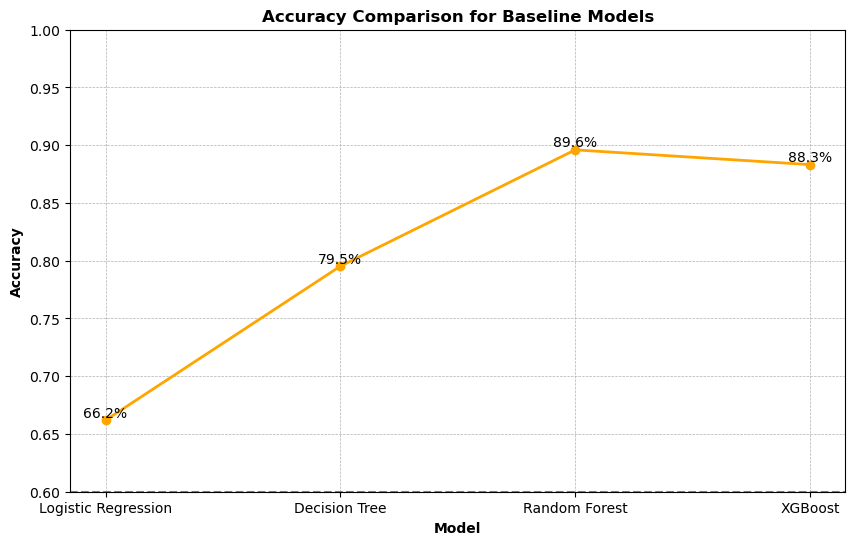

In [21]:
# List of model names and corresponding accuracy scores
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
accuracy_scores = [accuracy_lg, accuracy_dt, accuracy_rf, accuracy_xgb]

# Plot the line graph with an orange color theme and grid lines
plt.figure(figsize=(10, 6))
plt.plot(models, accuracy_scores, color='orange', marker='o', linestyle='-', linewidth=2)
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Accuracy Comparison for Baseline Models', fontweight='bold')
plt.ylim(0.6, 1.0)  # Set y-axis limits to 0.6 to 1.0
plt.axhline(y=0.6, color='gray', linestyle='--')  # Add a horizontal line at y=0.6 for reference

# Add accuracy score labels
for i, score in enumerate(accuracy_scores):
    plt.text(models[i], score, f"{score*100:.1f}%", ha='center', va='bottom')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add both horizontal and vertical grid lines
plt.show()

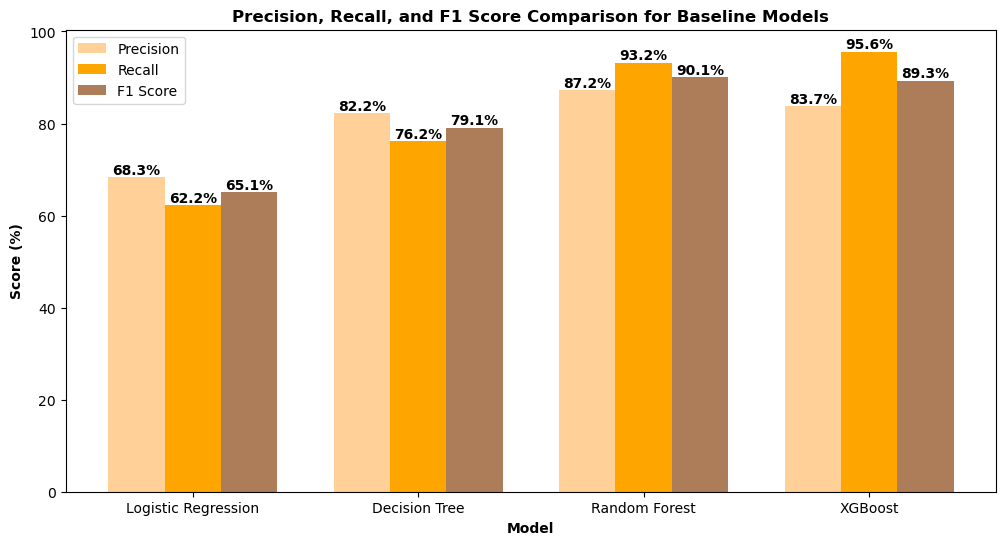

In [22]:
# List of model names and corresponding precision, recall, and F1 scores
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
precision_scores = [precision_lg, precision_dt, precision_rf, precision_xgb]
recall_scores = [recall_lg, recall_dt, recall_rf, recall_xgb]
f1_scores = [f1_lg, f1_dt, f1_rf, f1_xgb]

# Convert scores to percentages with one decimal place
precision_scores_pct = [round(score * 100, 1) for score in precision_scores]
recall_scores_pct = [round(score * 100, 1) for score in recall_scores]
f1_scores_pct = [round(score * 100, 1) for score in f1_scores]

# Set the positions and width for the bars
pos = np.arange(len(models))
width = 0.25

# Plot the bar graph for precision with an orange color theme
plt.figure(figsize=(12, 6))
plt.bar(pos, precision_scores_pct, width, color='darkorange', alpha=0.4, label='Precision')

# Plot the bar graph for recall with a darker orange color
plt.bar(pos + width, recall_scores_pct, width, color='orange', label='Recall')

# Plot the bar graph for F1 score with a much darker orange color
plt.bar(pos + 2 * width, f1_scores_pct, width, color='saddlebrown', alpha=0.7, label='F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Score (%)', fontweight='bold')
plt.title('Precision, Recall, and F1 Score Comparison for Baseline Models', fontweight='bold')
plt.xticks(pos + width, models, rotation=360)
plt.legend()

# Add score labels on top of the bars
for i in range(len(models)):
    plt.text(pos[i], precision_scores_pct[i], f"{precision_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')
    plt.text(pos[i] + width, recall_scores_pct[i], f"{recall_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')
    plt.text(pos[i] + 2 * width, f1_scores_pct[i], f"{f1_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')

plt.show()

## Hyperparameter Tuning <a class="anchor" id="hyperparameter"></a>

### Logistic Regression <a class="anchor" id="a"></a>

In [24]:
# Initialize the model
log_reg = LogisticRegression(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],  
    'penalty': ['l1', 'l2']       
}

# Initialize GridSearchCV with the model, parameter grid, and scoring metric
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Perform the hyperparameter search on the validation data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions using the best model
preds_tuned = best_model.predict(X_val)

# Compute metrics for the tuned model
accuracy_tuned = accuracy_score(y_val, preds_tuned)
precision_tuned = precision_score(y_val, preds_tuned)
recall_tuned = recall_score(y_val, preds_tuned)
f1_tuned = f1_score(y_val, preds_tuned)
conf_mat_tuned = confusion_matrix(y_val, preds_tuned)
clf_report_tuned = classification_report(y_val, preds_tuned)

# Print metrics for the tuned model
print("Tuned Logistic Regression Metrics:")
print(f"Best Hyperparameters: {best_params}")
print(f"Accuracy: {accuracy_tuned}")
print(f"Precision: {precision_tuned}")
print(f"Recall: {recall_tuned}")
print(f"F1 Score: {f1_tuned}")
print("Confusion Matrix:")
print(conf_mat_tuned)
print("Classification Report:")
print(clf_report_tuned)

Tuned Logistic Regression Metrics:
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2'}
Accuracy: 0.6635036496350365
Precision: 0.6876503608660786
Recall: 0.6169064748201439
F1 Score: 0.6503602578687904
Confusion Matrix:
[[1921  779]
 [1065 1715]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.71      0.68      2700
         1.0       0.69      0.62      0.65      2780

    accuracy                           0.66      5480
   macro avg       0.67      0.66      0.66      5480
weighted avg       0.67      0.66      0.66      5480



### Support Vector Machine <a class="anchor" id="b"></a>

This model will be tuned in the future, below is the code.

In [25]:
# Initialize the model
#svm = SVC(random_state=42)

# Define the hyperparameter grid to search
#param_grid = {
#    'C': [0.1, 1, 10],           
#    'kernel': ['linear', 'rbf']
#}

# Initialize GridSearchCV with the model, parameter grid, and scoring metric
#grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Perform the hyperparameter search on the validation data
#grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
#best_params = grid_search.best_params_
#best_model = grid_search.best_estimator_

# Make predictions using the best model
#preds_tuned = best_model.predict(X_val)

# Compute metrics for the tuned model
#accuracy_tuned = accuracy_score(y_val, preds_tuned)
#precision_tuned = precision_score(y_val, preds_tuned)
#recall_tuned = recall_score(y_val, preds_tuned)
#f1_tuned = f1_score(y_val, preds_tuned)
#conf_mat_tuned = confusion_matrix(y_val, preds_tuned)
#clf_report_tuned = classification_report(y_val, preds_tuned)

# Print metrics for the tuned model
#print("Tuned SVM Metrics:")
#print(f"Best Hyperparameters: {best_params}")
#print(f"Accuracy: {accuracy_tuned}")
#print(f"Precision: {precision_tuned}")
#print(f"Recall: {recall_tuned}")
#print(f"F1 Score: {f1_tuned}")
#print("Confusion Matrix:")
#print(conf_mat_tuned)
#print("Classification Report:")
#print(clf_report_tuned)

In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Initialize the model
svm = SVC(random_state=42)

# Define the hyperparameter grid to search
param_distributions = {
    'C': [0.1, 1, 10],           
    'kernel': ['linear', 'rbf']
}

# Initialize RandomizedSearchCV with the model, parameter grid, and scoring metric
random_search = RandomizedSearchCV(svm, param_distributions, n_iter=4, cv=3, scoring='f1', n_jobs=-1, random_state=42)

# Perform the hyperparameter search on the validation data
random_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Make predictions using the best model
preds_tuned = best_model.predict(X_val)

# Compute metrics for the tuned model
accuracy_tuned = accuracy_score(y_val, preds_tuned)
precision_tuned = precision_score(y_val, preds_tuned)
recall_tuned = recall_score(y_val, preds_tuned)
f1_tuned = f1_score(y_val, preds_tuned)
conf_mat_tuned = confusion_matrix(y_val, preds_tuned)
clf_report_tuned = classification_report(y_val, preds_tuned)

# Print metrics for the tuned model
print("Tuned SVM Metrics:")
print(f"Best Hyperparameters: {best_params}")
print(f"Accuracy: {accuracy_tuned}")
print(f"Precision: {precision_tuned}")
print(f"Recall: {recall_tuned}")
print(f"F1 Score: {f1_tuned}")
print("Confusion Matrix:")
print(conf_mat_tuned)
print("Classification Report:")
print(clf_report_tuned)


Tuned SVM Metrics:
Best Hyperparameters: {'kernel': 'rbf', 'C': 10}
Accuracy: 0.791058394160584
Precision: 0.8114285714285714
Recall: 0.7661870503597122
F1 Score: 0.7881591119333949
Confusion Matrix:
[[2205  495]
 [ 650 2130]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.82      0.79      2700
         1.0       0.81      0.77      0.79      2780

    accuracy                           0.79      5480
   macro avg       0.79      0.79      0.79      5480
weighted avg       0.79      0.79      0.79      5480



### Decision Tree <a class="anchor" id="c"></a>

In [27]:
# Initialize the model
dec_tree = DecisionTreeClassifier(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [None, 10, 20, 30],   
    'min_samples_split': [2, 5, 10],   
    'min_samples_leaf': [1, 2, 4]      
}

# Initialize GridSearchCV with the model, parameter grid, and scoring metric (F1 score)
grid_search = GridSearchCV(dec_tree, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Perform the hyperparameter search on the validation data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions using the best model
preds_tuned = best_model.predict(X_val)

# Compute metrics for the tuned model
accuracy_tuned = accuracy_score(y_val, preds_tuned)
precision_tuned = precision_score(y_val, preds_tuned)
recall_tuned = recall_score(y_val, preds_tuned)
f1_tuned = f1_score(y_val, preds_tuned)
conf_mat_tuned = confusion_matrix(y_val, preds_tuned)
clf_report_tuned = classification_report(y_val, preds_tuned)

# Print metrics for the tuned model
print("Tuned Decision Tree Metrics:")
print(f"Best Hyperparameters: {best_params}")
print(f"Accuracy: {accuracy_tuned}")
print(f"Precision: {precision_tuned}")
print(f"Recall: {recall_tuned}")
print(f"F1 Score: {f1_tuned}")
print("Confusion Matrix:")
print(conf_mat_tuned)
print("Classification Report:")
print(clf_report_tuned)

Tuned Decision Tree Metrics:
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.8021897810218979
Precision: 0.823170731707317
Recall: 0.7769784172661871
F1 Score: 0.7994078460399703
Confusion Matrix:
[[2236  464]
 [ 620 2160]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.83      0.80      2700
         1.0       0.82      0.78      0.80      2780

    accuracy                           0.80      5480
   macro avg       0.80      0.80      0.80      5480
weighted avg       0.80      0.80      0.80      5480



### Random Forest <a class="anchor" id="d"></a>

In [28]:
# Initialize the model
rand_forest = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [200, 300],         
    'max_depth': [None, 10],          
    'min_samples_split': [1, 2, 5],          
    'min_samples_leaf': [1, 2]           
}

# Initialize GridSearchCV with the model, parameter grid, and scoring metric (F1 score)
grid_search = GridSearchCV(rand_forest, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Perform the hyperparameter search on the validation data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions using the best model
preds_tuned = best_model.predict(X_val)

# Compute metrics for the tuned model
accuracy_tuned = accuracy_score(y_val, preds_tuned)
precision_tuned = precision_score(y_val, preds_tuned)
recall_tuned = recall_score(y_val, preds_tuned)
f1_tuned = f1_score(y_val, preds_tuned)
conf_mat_tuned = confusion_matrix(y_val, preds_tuned)
clf_report_tuned = classification_report(y_val, preds_tuned)

# Print metrics for the tuned model
print("Tuned Random Forest Metrics:")
print(f"Best Hyperparameters: {best_params}")
print(f"Accuracy: {accuracy_tuned}")
print(f"Precision: {precision_tuned}")
print(f"Recall: {recall_tuned}")
print(f"F1 Score: {f1_tuned}")
print("Confusion Matrix:")
print(conf_mat_tuned)
print("Classification Report:")
print(clf_report_tuned)

Tuned Random Forest Metrics:
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy: 0.8989051094890511
Precision: 0.8714953271028038
Recall: 0.9392086330935252
F1 Score: 0.9040858725761773
Confusion Matrix:
[[2315  385]
 [ 169 2611]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.86      0.89      2700
         1.0       0.87      0.94      0.90      2780

    accuracy                           0.90      5480
   macro avg       0.90      0.90      0.90      5480
weighted avg       0.90      0.90      0.90      5480



### XGBoost <a class="anchor" id="e"></a>

In [29]:
# Initialize the model
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300, 350],      
    'max_depth': [3, 5, 7],               
    'learning_rate': [0.01, 0.1, 0.2]     
}

# Initialize GridSearchCV with the model, parameter grid, and scoring metric (F1 score)
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Perform the hyperparameter search on the validation data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions using the best model
preds_tuned = best_model.predict(X_val)

# Compute metrics for the tuned model
accuracy_tuned = accuracy_score(y_val, preds_tuned)
precision_tuned = precision_score(y_val, preds_tuned)
recall_tuned = recall_score(y_val, preds_tuned)
f1_tuned = f1_score(y_val, preds_tuned)
conf_mat_tuned = confusion_matrix(y_val, preds_tuned)
clf_report_tuned = classification_report(y_val, preds_tuned)

# Print metrics for the tuned model
print("Tuned XGBoost Metrics:")
print(f"Best Hyperparameters: {best_params}")
print(f"Accuracy: {accuracy_tuned}")
print(f"Precision: {precision_tuned}")
print(f"Recall: {recall_tuned}")
print(f"F1 Score: {f1_tuned}")
print("Confusion Matrix:")
print(conf_mat_tuned)
print("Classification Report:")
print(clf_report_tuned)

Tuned XGBoost Metrics:
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Accuracy: 0.8859489051094891
Precision: 0.8339014564611094
Recall: 0.9679856115107913
F1 Score: 0.8959547194939237
Confusion Matrix:
[[2164  536]
 [  89 2691]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.80      0.87      2700
         1.0       0.83      0.97      0.90      2780

    accuracy                           0.89      5480
   macro avg       0.90      0.88      0.88      5480
weighted avg       0.90      0.89      0.89      5480



### Summary of Hyperparameter Tuning

In [30]:
# Set the maximum column width to -1 to display all the text in a column
pd.set_option('display.max_colwidth', None)

# Create a DataFrame with the best parameters for each model
best_params_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Best Parameters': [
        {'C': 0.1, 'penalty': 'l2'},
        {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2},
        {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300},
        {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
    ]
})

print(best_params_df)

                 Model  \
0  Logistic Regression   
1        Decision Tree   
2        Random Forest   
3              XGBoost   

                                                                              Best Parameters  
0                                                                 {'C': 0.1, 'penalty': 'l2'}  
1  {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}  
2     {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}  
3                                 {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}  


## Fit the models with the best parameters <a class="anchor" id="tune"></a>

### Logistic Regression

In [55]:
# Fit the model
log_reg_model  = LogisticRegression(C=0.1, penalty='l2', random_state=42)
log_reg_model.fit(X_train, y_train)

# Make predictions
preds = log_reg_model.predict(X_val)

# Compute metrics
accuracy_lg1 = accuracy_score(y_val, preds)
precision_lg1 = precision_score(y_val, preds)
recall_lg1 = recall_score(y_val, preds)
f1_lg1 = f1_score(y_val, preds)
conf_mat_lg1 = confusion_matrix(y_val, preds)
clf_report_lg1 = classification_report(y_val, preds)

# Print metrics
print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_lg1}")
print(f"Precision: {precision_lg1}")
print(f"Recall: {recall_lg1}")
print(f"F1 Score: {f1_lg1}")
print("Confusion Matrix:")
print(conf_mat_lg1)
print("Classification Report:")
print(clf_report_lg1)

Logistic Regression Metrics:
Accuracy: 0.6635036496350365
Precision: 0.6876503608660786
Recall: 0.6169064748201439
F1 Score: 0.6503602578687904
Confusion Matrix:
[[1921  779]
 [1065 1715]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.71      0.68      2700
         1.0       0.69      0.62      0.65      2780

    accuracy                           0.66      5480
   macro avg       0.67      0.66      0.66      5480
weighted avg       0.67      0.66      0.66      5480



### Decision Tree


In [56]:
# Fit the model
dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=2, random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions
preds = dt_model.predict(X_val)

# Compute metrics
accuracy_dt1 = accuracy_score(y_val, preds)
precision_dt1 = precision_score(y_val, preds)
recall_dt1 = recall_score(y_val, preds)
f1_dt1 = f1_score(y_val, preds)
conf_mat_dt1 = confusion_matrix(y_val, preds)
clf_report_dt1 = classification_report(y_val, preds)

# Print metrics
print("Decision Tree Metrics:")
print(f"Accuracy: {accuracy_dt1}")
print(f"Precision: {precision_dt1}")
print(f"Recall: {recall_dt1}")
print(f"F1 Score: {f1_dt1}")
print("Confusion Matrix:")
print(conf_mat_dt1)
print("Classification Report:")
print(clf_report_dt1)

Decision Tree Metrics:
Accuracy: 0.8021897810218979
Precision: 0.823170731707317
Recall: 0.7769784172661871
F1 Score: 0.7994078460399703
Confusion Matrix:
[[2236  464]
 [ 620 2160]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.83      0.80      2700
         1.0       0.82      0.78      0.80      2780

    accuracy                           0.80      5480
   macro avg       0.80      0.80      0.80      5480
weighted avg       0.80      0.80      0.80      5480



### Random Forest

In [57]:
# Fit the model
rf_model = RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_leaf=1, min_samples_split=2, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
preds = rf_model.predict(X_val)

# Compute metrics
accuracy_rf1 = accuracy_score(y_val, preds)
precision_rf1 = precision_score(y_val, preds)
recall_rf1 = recall_score(y_val, preds)
f1_rf1 = f1_score(y_val, preds)
conf_mat_rf1 = confusion_matrix(y_val, preds)
clf_report_rf1 = classification_report(y_val, preds)

# Print metrics
print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_rf1}")
print(f"Precision: {precision_rf1}")
print(f"Recall: {recall_rf1}")
print(f"F1 Score: {f1_rf1}")
print("Confusion Matrix:")
print(conf_mat_rf1)
print("Classification Report:")
print(clf_report_rf1)

Random Forest Metrics:
Accuracy: 0.8989051094890511
Precision: 0.8714953271028038
Recall: 0.9392086330935252
F1 Score: 0.9040858725761773
Confusion Matrix:
[[2315  385]
 [ 169 2611]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.86      0.89      2700
         1.0       0.87      0.94      0.90      2780

    accuracy                           0.90      5480
   macro avg       0.90      0.90      0.90      5480
weighted avg       0.90      0.90      0.90      5480



### XGBoost <a class="anchor" id="e"></a>

In [58]:
# Fit the model
xgb_model = XGBClassifier(learning_rate=0.1, max_depth=7, n_estimators=200, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Make predictions
preds = xgb_model.predict(X_val)

# Compute metrics
accuracy_xgb1 = accuracy_score(y_val, preds)
precision_xgb1 = precision_score(y_val, preds)
recall_xgb1 = recall_score(y_val, preds)
f1_xgb1 = f1_score(y_val, preds)
conf_mat_xgb1 = confusion_matrix(y_val, preds)
clf_report_xgb1 = classification_report(y_val, preds)

# Print metrics
print("XGBoost Metrics:")
print(f"Accuracy: {accuracy_xgb1}")
print(f"Precision: {precision_xgb1}")
print(f"Recall: {recall_xgb1}")
print(f"F1 Score: {f1_xgb1}")
print("Confusion Matrix:")
print(conf_mat_xgb1)
print("Classification Report:")
print(clf_report_xgb1)

XGBoost Metrics:
Accuracy: 0.8908759124087591
Precision: 0.8411507191994997
Recall: 0.9676258992805755
F1 Score: 0.899966543994647
Confusion Matrix:
[[2192  508]
 [  90 2690]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88      2700
         1.0       0.84      0.97      0.90      2780

    accuracy                           0.89      5480
   macro avg       0.90      0.89      0.89      5480
weighted avg       0.90      0.89      0.89      5480



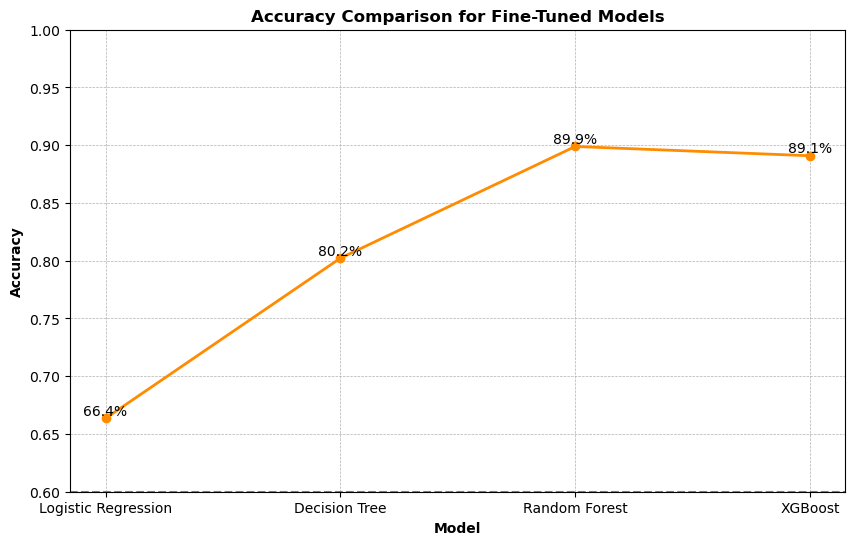

In [59]:
# List of model names and corresponding accuracy scores
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
accuracy_scores = [accuracy_lg1, accuracy_dt1, accuracy_rf1, accuracy_xgb1]

# Plot the line graph with an orange color theme and grid lines
plt.figure(figsize=(10, 6))
plt.plot(models, accuracy_scores, color='darkorange', marker='o', linestyle='-', linewidth=2)
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Accuracy Comparison for Fine-Tuned Models', fontweight='bold')
plt.ylim(0.6, 1.0)  # Set y-axis limits to 0.6 to 1.0
plt.axhline(y=0.6, color='gray', linestyle='--')  # Add a horizontal line at y=0.6 for reference

# Add accuracy score labels
for i, score in enumerate(accuracy_scores):
    plt.text(models[i], score, f"{score*100:.1f}%", ha='center', va='bottom')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add both horizontal and vertical grid lines
plt.show()

#### precision, recall, and F1 scores

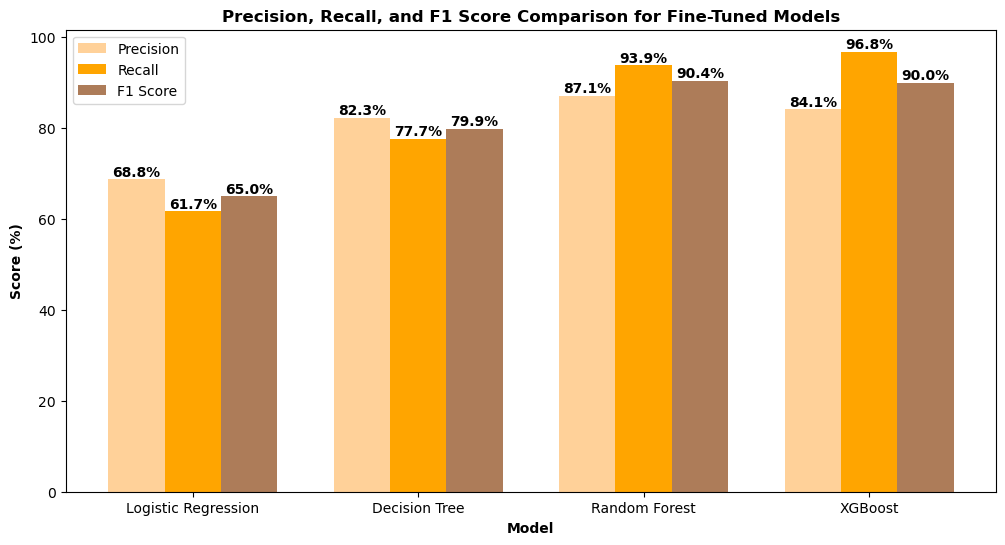

In [60]:
# List of model names and corresponding precision, recall, and F1 scores
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
precision_scores = [precision_lg1, precision_dt1, precision_rf1, precision_xgb1]
recall_scores = [recall_lg1, recall_dt1, recall_rf1, recall_xgb1]
f1_scores = [f1_lg1, f1_dt1, f1_rf1, f1_xgb1]

# Convert scores to percentages with one decimal place
precision_scores_pct = [round(score * 100, 1) for score in precision_scores]
recall_scores_pct = [round(score * 100, 1) for score in recall_scores]
f1_scores_pct = [round(score * 100, 1) for score in f1_scores]

# Set the positions and width for the bars
pos = np.arange(len(models))
width = 0.25

# Plot the bar graph for precision with an orange color theme
plt.figure(figsize=(12, 6))
plt.bar(pos, precision_scores_pct, width, color='darkorange', alpha=0.4, label='Precision')

# Plot the bar graph for recall with a darker orange co
plt.bar(pos + width, recall_scores_pct, width, color='orange', label='Recall')

# Plot the bar graph for F1 score with a much darker orange color
plt.bar(pos + 2 * width, f1_scores_pct, width, color='saddlebrown', alpha=0.7, label='F1 Score')

# Add xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold')
plt.ylabel('Score (%)', fontweight='bold')
plt.title('Precision, Recall, and F1 Score Comparison for Fine-Tuned Models', fontweight='bold')
plt.xticks(pos + width, models, rotation=360)
plt.legend()

# Add score labels on top of the bars
for i in range(len(models)):
    plt.text(pos[i], precision_scores_pct[i], f"{precision_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')
    plt.text(pos[i] + width, recall_scores_pct[i], f"{recall_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')
    plt.text(pos[i] + 2 * width, f1_scores_pct[i], f"{f1_scores_pct[i]:.1f}%", ha='center', va='bottom', fontweight='bold')

plt.show()

### Summary of Tuned Models

In [61]:
# Create an empty DataFrame to store the metrics
tuned_metrics_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Add the metrics for the tuned models
tuned_metrics_df.loc['Logistic Regression'] = [accuracy_lg1, precision_lg1, recall_lg1, f1_lg1]
tuned_metrics_df.loc['Decision Tree'] = [accuracy_dt1, precision_dt1, recall_dt1, f1_dt1]
tuned_metrics_df.loc['Random Forest'] = [accuracy_rf1, precision_rf1, recall_rf1, f1_rf1]
tuned_metrics_df.loc['XGBoost'] = [accuracy_xgb1, precision_xgb1, recall_xgb1, f1_xgb1]

# Print the comparison table
print(tuned_metrics_df)

                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.663504   0.687650  0.616906  0.650360
Decision Tree        0.802190   0.823171  0.776978  0.799408
Random Forest        0.898905   0.871495  0.939209  0.904086
XGBoost              0.890876   0.841151  0.967626  0.899967


In [52]:
# Convert to percentages and round to 2 decimal places
tuned_metrics_df = tuned_metrics_df.apply(lambda x: round(x * 100, 2))

# Add '%' symbol
tuned_metrics_df = tuned_metrics_df.applymap(lambda x: f"{x}%")

print(tuned_metrics_df)

                    Accuracy Precision  Recall F1 Score
Logistic Regression   66.35%    68.77%  61.69%   65.04%
Decision Tree         80.22%    82.32%   77.7%   79.94%
Random Forest         89.89%    87.15%  93.92%   90.41%
XGBoost               89.09%    84.12%  96.76%    90.0%


## Compare Baseline Models vs. Tuned Models

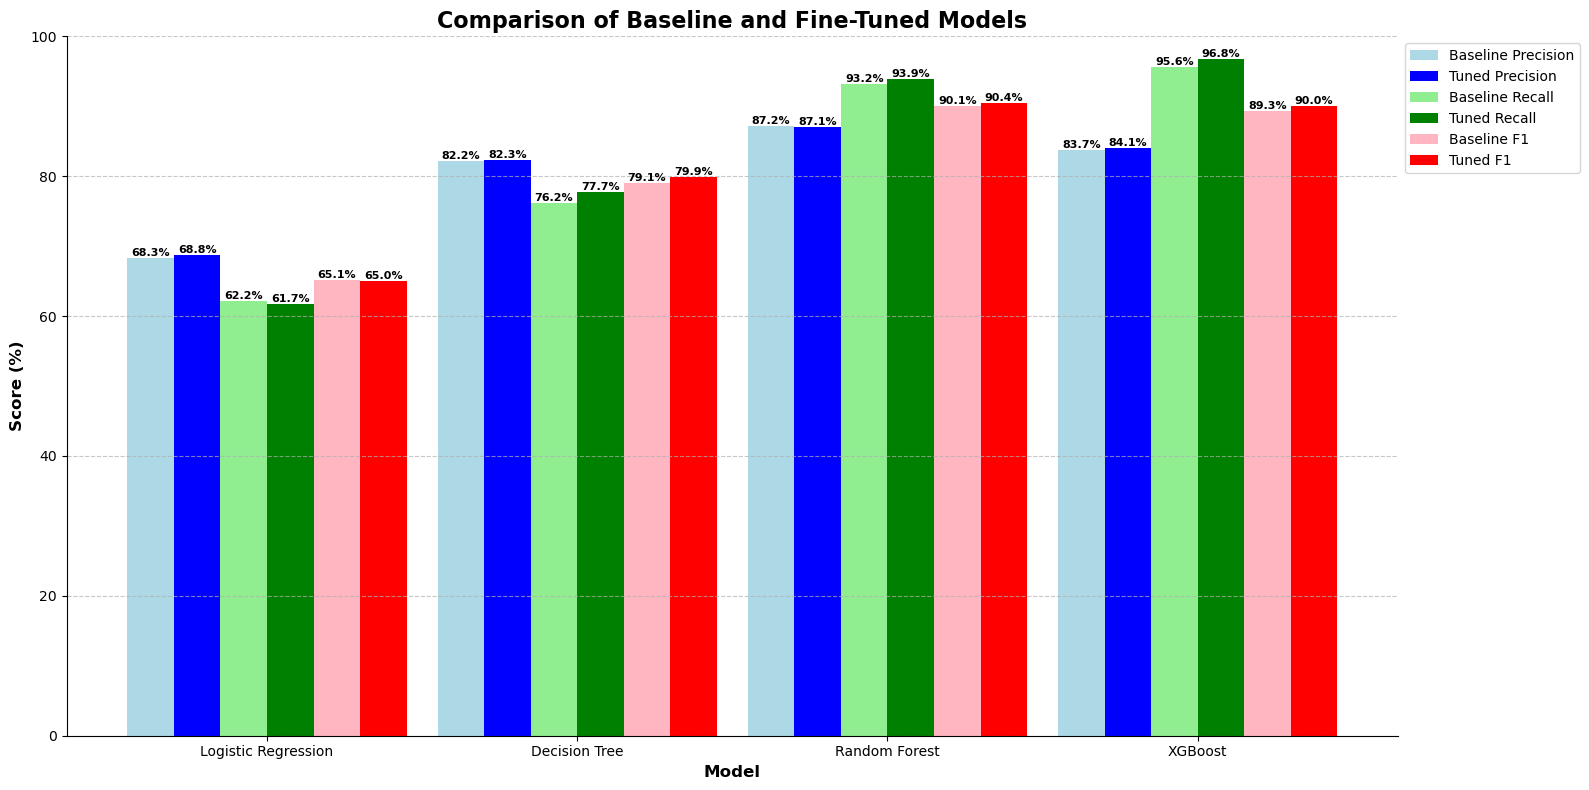

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# List of model names
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']

# Baseline model scores
precision_scores_base = [precision_lg, precision_dt, precision_rf, precision_xgb]
recall_scores_base = [recall_lg, recall_dt, recall_rf, recall_xgb]
f1_scores_base = [f1_lg, f1_dt, f1_rf, f1_xgb]

# Fine-tuned model scores
precision_scores_tuned = [precision_lg1, precision_dt1, precision_rf1, precision_xgb1]
recall_scores_tuned = [recall_lg1, recall_dt1, recall_rf1, recall_xgb1]
f1_scores_tuned = [f1_lg1, f1_dt1, f1_rf1, f1_xgb1]

# Convert scores to percentages with one decimal place
def to_percent(scores):
    return [round(score * 100, 1) for score in scores]

precision_base_pct = to_percent(precision_scores_base)
recall_base_pct = to_percent(recall_scores_base)
f1_base_pct = to_percent(f1_scores_base)

precision_tuned_pct = to_percent(precision_scores_tuned)
recall_tuned_pct = to_percent(recall_scores_tuned)
f1_tuned_pct = to_percent(f1_scores_tuned)

# Set the positions and width for the bars
pos = np.arange(len(models))
width = 0.15  # Adjusted width to fit all bars

# Create the plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot bars for precision
ax.bar(pos - 2*width, precision_base_pct, width, color='lightblue', label='Baseline Precision')
ax.bar(pos - width, precision_tuned_pct, width, color='blue', label='Tuned Precision')

# Plot bars for recall
ax.bar(pos, recall_base_pct, width, color='lightgreen', label='Baseline Recall')
ax.bar(pos + width, recall_tuned_pct, width, color='green', label='Tuned Recall')

# Plot bars for F1 score
ax.bar(pos + 2*width, f1_base_pct, width, color='lightpink', label='Baseline F1')
ax.bar(pos + 3*width, f1_tuned_pct, width, color='red', label='Tuned F1')

# Customize the chart
ax.set_xlabel('Model', fontweight='bold', fontsize=12)
ax.set_ylabel('Score (%)', fontweight='bold', fontsize=12)
ax.set_title('Comparison of Baseline and Fine-Tuned Models', fontweight='bold', fontsize=16)
ax.set_xticks(pos + 0.5*width)
ax.set_xticklabels(models, rotation=0, ha='center')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Function to add value labels
def add_labels(offsets, values):
    for offset, value in zip(offsets, values):
        ax.text(offset, value, f'{value}%', ha='center', va='bottom', fontsize=8, fontweight='bold')

# Add value labels
for i in range(len(models)):
    add_labels(pos[i] + np.array([-2, -1, 0, 1, 2, 3])*width, 
               [precision_base_pct[i], precision_tuned_pct[i],
                recall_base_pct[i], recall_tuned_pct[i],
                f1_base_pct[i], f1_tuned_pct[i]])

# Adjust layout and display
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100%
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [54]:
# Rename the index for the baseline models
metrics_df.index = ['Baseline Logistic Regression', #'Baseline SVM', 
                    'Baseline Decision Tree', 'Baseline Random Forest', 'Baseline XGBoost']

# Rename the index for the tuned models
tuned_metrics_df.index = ['Tuned Logistic Regression', 'Tuned Decision Tree', 
                          'Tuned Random Forest', 'Tuned XGBoost']

# Reorder the rows
all_metrics_df = pd.concat([
    metrics_df.loc[['Baseline Logistic Regression']],
    tuned_metrics_df.loc[['Tuned Logistic Regression']],
    #metrics_df.loc[['Baseline SVM']],
    metrics_df.loc[['Baseline Decision Tree']],
    tuned_metrics_df.loc[['Tuned Decision Tree']],
    metrics_df.loc[['Baseline Random Forest']],
    tuned_metrics_df.loc[['Tuned Random Forest']],
    metrics_df.loc[['Baseline XGBoost']],
    tuned_metrics_df.loc[['Tuned XGBoost']]
])

# Print the comparison table
print(all_metrics_df)

                              Accuracy Precision    Recall  F1 Score
Baseline Logistic Regression  0.661861  0.682985  0.622302  0.651233
Tuned Logistic Regression       66.35%    68.77%    61.69%    65.04%
Baseline Decision Tree        0.795255  0.821817  0.761511  0.790515
Tuned Decision Tree             80.22%    82.32%     77.7%    79.94%
Baseline Random Forest        0.895985  0.871803  0.932014  0.900904
Tuned Random Forest             89.89%    87.15%    93.92%    90.41%
Baseline XGBoost              0.883212  0.837114  0.955755  0.892509
Tuned XGBoost                   89.09%    84.12%    96.76%     90.0%
